# Load GFS data

> Requires `[gfs]` optional dependencies:
>
> ```
> $ pip install pycontrails[gfs]
> ```

### References

- [NOAA GFS](https://registry.opendata.aws/noaa-gfs-bdp-pds/) - AWS Open Data Registry
- [NCEI GFS Documentation](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)
- [NOAA GFS Documentation](https://vlab.noaa.gov/web/gfs/documentation)
- [Parameter definitions](https://www.nco.ncep.noaa.gov/pmb/products/gfs/)
    
See [API Reference](https://py.contrails.org/api.html#gfs) for usage.

In [1]:
import numpy as np

from pycontrails.datalib.gfs import GFSForecast

In [2]:
# get a single time
gfs = GFSForecast(
    time="2022-03-01 01:00:00",
    variables=["t", "q"],  # Supports CF name or short names
    pressure_levels=[200, 250, 300],
    show_progress=True,  # Shows download progress from AWS
)
gfs

GFSForecast
	Timesteps: ['2022-03-01 01']
	Variables: ['t', 'q']
	Pressure levels: [200, 250, 300]
	Grid: 0.25
	Forecast time: 2022-03-01 00:00:00

In [3]:
# get a range of time
gfs = GFSForecast(
    time=("2022-03-01 00:00:00", "2022-03-01 02:00:00"),
    variables=[
        "air_temperature",
        "q",
    ],  # supports CF name or short names
    pressure_levels=[200, 250, 300],
    show_progress=True,
)
gfs

GFSForecast
	Timesteps: ['2022-03-01 00', '2022-03-01 01', '2022-03-01 02']
	Variables: ['t', 'q']
	Pressure levels: [200, 250, 300]
	Grid: 0.25
	Forecast time: 2022-03-01 00:00:00

In [4]:
# this triggers a download from AWS if file isn't in cache store
met = gfs.open_metdataset()
met

MetDataset with data:

<xarray.Dataset>
Dimensions:            (longitude: 1440, latitude: 721, level: 3, time: 3)
Coordinates:
  * level              (level) float64 200.0 250.0 300.0
  * latitude           (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude          (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    forecast_time      datetime64[ns] 2022-03-01
  * time               (time) datetime64[ns] 2022-03-01 ... 2022-03-01T02:00:00
    air_pressure       (level) float32 2e+04 2.5e+04 3e+04
    altitude           (level) float32 1.178e+04 1.036e+04 9.164e+03
Data variables:
    air_temperature    (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 3, 1), meta=np.ndarray>
    specific_humidity  (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 3, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-07-12T15:51 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.49.3.dev50
    provider:                NCEP
    dataset:                 GFS
    product:                 forecast

In [5]:
# get steps for a specific forecast time
time_bounds = ("2022-11-18 16:00:00", "2022-11-18 18:00:00")
gfs = GFSForecast(
    time_bounds,
    variables=["t", "q"],
    pressure_levels=[200, 250, 300, 350],
    forecast_time=np.datetime64("2022-11-17 00:06:00"),
    show_progress=True,
)
gfs

GFSForecast
	Timesteps: ['2022-11-18 16', '2022-11-18 17', '2022-11-18 18']
	Variables: ['t', 'q']
	Pressure levels: [200, 250, 300, 350]
	Grid: 0.25
	Forecast time: 2022-11-17 00:00:00

## Run CoCiP with GFS

See the [CoCiP Notebook](https://py.contrails.org/notebooks/CoCiP.html) for more details on running the CoCiP model.

In [6]:
import numpy as np
import pandas as pd

from pycontrails import Flight
from pycontrails.models.cocip import Cocip

In [7]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
pressure_levels = [300, 250, 200]

gfs_met = GFSForecast(
    time_bounds, variables=Cocip.met_variables, pressure_levels=pressure_levels, show_progress=True
)

gfs_rad = GFSForecast(time_bounds, variables=Cocip.rad_variables, show_progress=True)

In [8]:
# download data from AWS (or open from cache)
met = gfs_met.open_metdataset()
rad = gfs_rad.open_metdataset()

In [9]:
# demo synthetic flight
flight_attrs = {
    "flight_id": "test",
    # set constants along flight path
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,  # non-volatile emissions index
    "aircraft_type": "E190",
    "wingspan": 48,  # m
    "n_engine": 2,
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-25, -40, 100)
df["latitude"] = np.linspace(34, 40, 100)
df["altitude"] = np.linspace(10900, 10900, 100)
df["engine_efficiency"] = np.linspace(0.34, 0.35, 100)
df["fuel_flow"] = np.linspace(2.1, 2.4, 100)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154345, 100)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=100)

flight = Flight(df, attrs=flight_attrs)

In [10]:
# set up CoCiP model with GFS meteorology and radiation
params = {"dt_integration": np.timedelta64(10, "m")}
cocip = Cocip(met=met, rad=rad, params=params)

In [11]:
# evaluate flight in CoCiP model
output_flight = cocip.eval(source=flight)

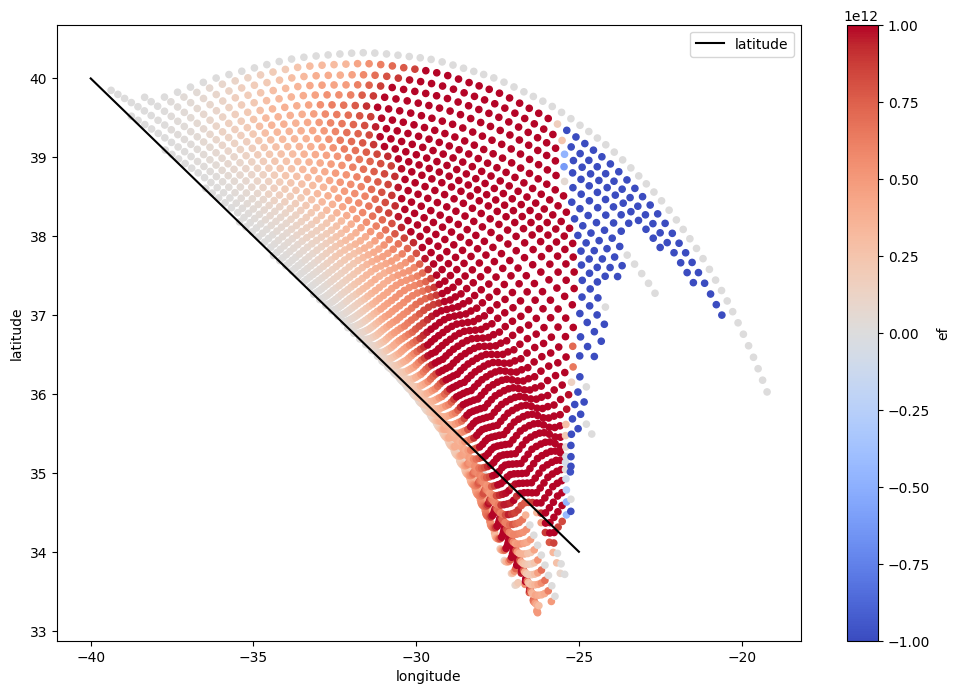

In [12]:
# review the energy forcing from flight segments
ax = cocip.source.dataframe.plot("longitude", "latitude", color="k", figsize=(12, 8))
cocip.contrail.plot.scatter(
    "longitude", "latitude", c="ef", cmap="coolwarm", vmin=-1e12, vmax=1e12, ax=ax
);